In [35]:
#pip install fancyimpute scikit-learn


In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

In [3]:
#impute for 400+ ppl missing FORMER_REG + JOB_REG - done 
#do imputation for people with "Retired_missing" + "Employed_missing" labels
#check the command about encoding part linear model

## Load data

In [8]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)


## DATA CLEANING

## Simplification of categories

In [12]:
# Merge sports data and extract sports categories
def extract_sports_category(dataset, sports_code):
    merged = pd.merge(dataset, sports_code, left_on="Sports", right_on="Code")
    merged["Sports_Category"] = merged["Categorie"]
    return merged[["PRIMARY_KEY", "Sports_Category"]]

learn_sports = extract_sports_category(learn_dataset_sport, code_Sports)
test_sports = extract_sports_category(test_dataset_sport, code_Sports)

# Merge departments into regions and extract relevant region columns
def merge_and_extract_region(df, merge_column, region_column_name):
    merged = pd.merge(df, departments, left_on=merge_column, right_on="DEP", how="left")
    merged[region_column_name] = merged["REG"]
    return merged.drop(["Nom du département", "REG", "DEP", merge_column], axis=1)

In [14]:
learn_dataset_job = merge_and_extract_region(learn_dataset_job, "JOB_DEP", "JOB_REG")    #put the column as int 
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "JOB_DEP", "JOB_REG")
learn_dataset_retired_jobs = merge_and_extract_region(learn_dataset_retired_jobs, "FORMER_DEP", "FORMER_REG")

test_dataset_job = merge_and_extract_region(test_dataset_job, "JOB_DEP", "JOB_REG")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "JOB_DEP", "JOB_REG")
test_dataset_retired_jobs = merge_and_extract_region(test_dataset_retired_jobs, "FORMER_DEP", "FORMER_REG")

In [16]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

In [18]:
code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0] + 1

#issue in the code IZ should be its own category "Hébergement et restauration"
#HZ, JZ à MC so LZ, KZ, MA, MB and MC, NZ, OZ, PZ,  QA, QB, RZ, SZ, TZ et UZ should be in the same category

In [20]:
code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0] + 1
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1

## Merging

In [23]:
learn_data = learn_dataset

learn_data = pd.merge(learn_data, code_act, left_on="act", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé"], axis=1, inplace=True)  #should also drop act ?
learn_data = pd.merge(learn_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
learn_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

#for imputation fitting
learn_data = pd.merge(learn_data, city_pop, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_loc, on="INSEE_CODE", how="left")
learn_data = pd.merge(learn_data, city_adm, on="INSEE_CODE", how="left")
learn_data = merge_and_extract_region(learn_data, "DEP", "CURRENT_REG")

test_data = test_dataset

test_data = pd.merge(test_data, code_act, left_on="act", right_on="Code", how="left")
test_data.drop(["Code", "Libellé"], axis=1, inplace=True)
test_data = pd.merge(test_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
test_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

test_data = pd.merge(test_data, city_pop, on="INSEE_CODE", how="left")
test_data = pd.merge(test_data, city_loc, on="INSEE_CODE", how="left")
test_data = pd.merge(test_data, city_adm, on="INSEE_CODE", how="left")
test_data = merge_and_extract_region(test_data, "DEP", "CURRENT_REG")

In [25]:
learn_dfs = [learn_dataset_emp_contract, learn_dataset_job, learn_dataset_retired_former, 
             learn_dataset_retired_jobs, learn_dataset_retired_pension, learn_sports]

test_dfs = [test_dataset_emp_contract, test_dataset_job, test_dataset_retired_former, 
            test_dataset_retired_jobs, test_dataset_retired_pension, test_sports]

for df in learn_dfs:
    learn_data = pd.merge(learn_data, df, on="PRIMARY_KEY", how="outer")

for df in test_dfs:
    test_data = pd.merge(test_data, df, on="PRIMARY_KEY", how="outer")

In [26]:
# Function to combine columns ending with `_x` and `_y` into a single base column
def combine_duplicate_columns(dataframe):
    for column in dataframe.columns:
        if column.endswith('_x'):
            base_column = column[:-2]  # Remove `_x` suffix
            y_column = base_column + '_y'
            if y_column in dataframe.columns:
                # Combine the `_x` and `_y` columns
                dataframe[base_column] = dataframe[column].fillna(dataframe[y_column])
                # Drop the original `_x` and `_y` columns
                dataframe.drop(columns=[column, y_column], inplace=True)
    return dataframe

In [29]:
learn_data = combine_duplicate_columns(learn_data)
test_data = combine_duplicate_columns(test_data)

## Formatting 

In [31]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None 

In [34]:
code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
learn_data['HOUSEHOLD_TYPE'] = learn_data['HOUSEHOLD_TYPE'].apply(household_num)
test_data['HOUSEHOLD_TYPE'] = test_data['HOUSEHOLD_TYPE'].apply(household_num)

In [36]:
def combine_columns(primary_col, fallback_col): #this is imputation
    """Combine two columns, filling missing values in the primary column with values from the fallback column."""
    return primary_col.fillna(fallback_col) if fallback_col is not None else primary_col 

def preprocess_employee_data(data, economic_sector_code, work_description_map):
    data["employee_count"] = data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")
    data["Employer_category"] = data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")
    
    
    data = data.merge(economic_sector_code, left_on="Economic_sector", right_on="Code", how="left")
    
    # Merge with work description map and clean up columns
    data = data.merge(work_description_map, left_on="work_description", right_on="N3", how="left")
    data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
    data["work_description"] = data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
    data.drop("N1", axis=1, inplace=True)
    
    # Combine relevant columns for contracts and pay
    data["emp_contract"] = combine_columns(data["emp_contract"], data["former_emp_contract"])
    data["Pay"] = combine_columns(data["Pay"], data["RETIREMENT_PAY"])
    data["JOB_REG"] = combine_columns(data["JOB_REG"], data["FORMER_REG"])  
    data["FORMER_REG"] = combine_columns(data["FORMER_REG"], data["JOB_REG"])
    data.loc[~data['JOB_42'].astype(str).str.startswith('csp_7'), 'JOB_REG'] = combine_columns(data['JOB_REG'], data['CURRENT_REG'])
 
    return data

In [38]:
learn_data = preprocess_employee_data(learn_data, code_Economic_sector, code_work_description_map)
test_data = preprocess_employee_data(test_data, code_Economic_sector, code_work_description_map)

In [40]:
def preprocess_column_types(data):
    data["sex"] = pd.factorize(data["sex"])[0]
    data["studying"] = data["studying"].astype("int64")
    data["Sports_Category"] = data["Sports_Category"].fillna(0).astype("int64")
    
    # List of columns to convert to Int64
    int_columns = ["CURRENT_REG", "JOB_REG", "FORMER_REG", "retirement_age", "WORKING_HOURS", "Economic_sector_num", "Pay"]
    
    for col in int_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')
    
    return data

In [42]:
learn_data = preprocess_column_types(learn_data)
test_data = preprocess_column_types(test_data)

# Labelling non-imputable values

In [45]:
def replace_na_with_unemployed(data, column_name):
    data[column_name] = data[column_name].astype('category')
    
    additional_categories = ['Unemployed']     
    
    # Add the specified categories
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    
    # Assign categories based on conditions
    data.loc[(data[column_name].isna()) & ((data['JOB_42'].astype(str).str.startswith('csp_8')) | (data['act_num'] == 2)), column_name] = 'Unemployed'

# List of columns to process
columns_to_process = [
    "emp_contract", "TYPE_OF_CONTRACT", "WORK_CONDITION", "Employer_category",
    "labor_force_status", "Economic_sector_num", "JOB_REG", "employee_count",
    "FORMER_REG", "work_description", "retirement_age", "FORMER_JOB_42"
]

for column in columns_to_process:
    replace_na_with_unemployed(learn_data, column)
    replace_na_with_unemployed(test_data, column)

In [46]:
def replace_na_with_employed(data, column_name):
    data[column_name] = data[column_name].astype('category')
    additional_categories = ['Employed']     
    data[column_name] = data[column_name].cat.add_categories(additional_categories)
    data.loc[(data[column_name].isna()) & (data['act_num'] == 1), column_name] = 'Employed'

columns_to_process = [ 
    "FORMER_REG", "retirement_age", "FORMER_JOB_42"
]

for column in columns_to_process:
    replace_na_with_employed(learn_data, column)
    replace_na_with_employed(test_data, column)

In [49]:
def clean_data(data, drop_columns):
    #simplify JOB_42?
    data["JOB_42_simple"] = data["JOB_42"].str.extract(r'csp_(\d+)_\d+')[0].astype("Int64")

    # Fill missing Pay and WORKING_HOURS for unemployed
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['Pay'].isna()), 'Pay'] = 0
    data.loc[(data['emp_contract'] == 'Unemployed') & (data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 0
    
    return data.drop(columns=drop_columns)


# Define columns to drop for each dataset
drop_columns = [
    "act", "former_emp_contract", "RETIREMENT_PAY", 
    "Economic_sector", "Code", "Libellé", "municipality_type",
    "Nomenclature", "X", "Y", "INSEE_CODE", "Nom de la commune"
]

In [51]:
learn_data = clean_data(learn_data, drop_columns)
test_data = clean_data(test_data, drop_columns)

#make sure to drop one of the JOB_42 cols later - simplified or not

#  Investigate reason for missing values 

In [54]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns



# Convert the missing values table to LaTeX format
#latex_learn_data = missing_values_learn_data.to_latex(index=False, float_format="%.2f")
#latex_test_data = missing_values_test_data.to_latex(index=False, float_format="%.2f")

#with open("./missing_values_learn_data.tex", "w") as file:
#    file.write(latex_learn_data)
#with open("./missing_values_test_data.tex", "w") as file:
#    file.write(latex_test_data)


In [56]:
print(missing_values_table(learn_data)) 
print(missing_values_table(test_data)) 

There are 11 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              8317               16.6
employee_count                 8129               16.2
WORKING_HOURS                  6957               13.9
Pay                            6939               13.9
TYPE_OF_CONTRACT               6939               13.9
WORK_CONDITION                 6939               13.9
labor_force_status             6939               13.9
Economic_sector_num            6939               13.9
work_description               6939               13.9
FORMER_REG                     2418                4.8
JOB_REG                        2418                4.8
There are 11 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              8260               16.5
employee_count                 8080               16.1
WORKING_HOURS                  6879               13.7
Pay                       

In [58]:
def plot_na_correlation(df):
    """
    Plots the correlation matrix of missing values in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame with missing values.
    """
    # Calculate correlation of missing values
    missing_corr = df.isnull().corr()

    # Mask to hide the upper triangle
    mask = np.triu(np.ones_like(missing_corr, dtype=bool))

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, cbar=True)
    plt.title("Correlation of Missing Values")
    plt.show()


Correlation of Missing Values for Learn Data


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


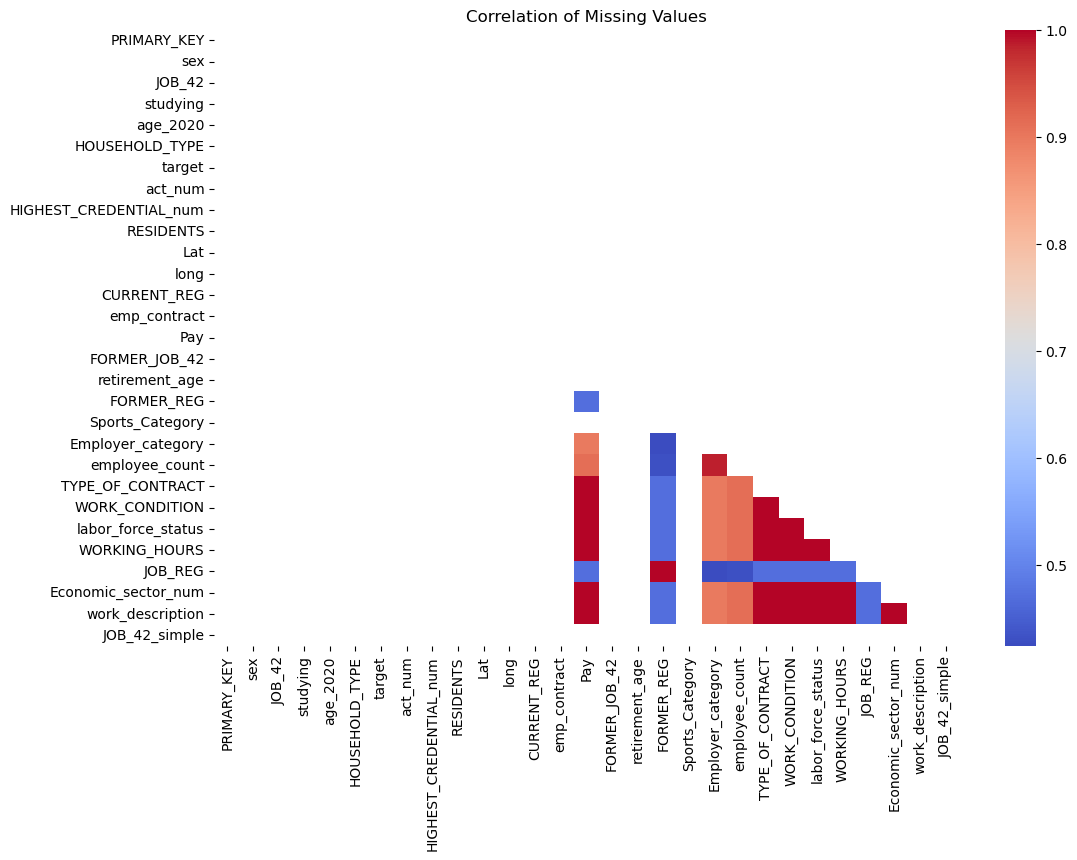

Correlation of Missing Values for Test Data


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


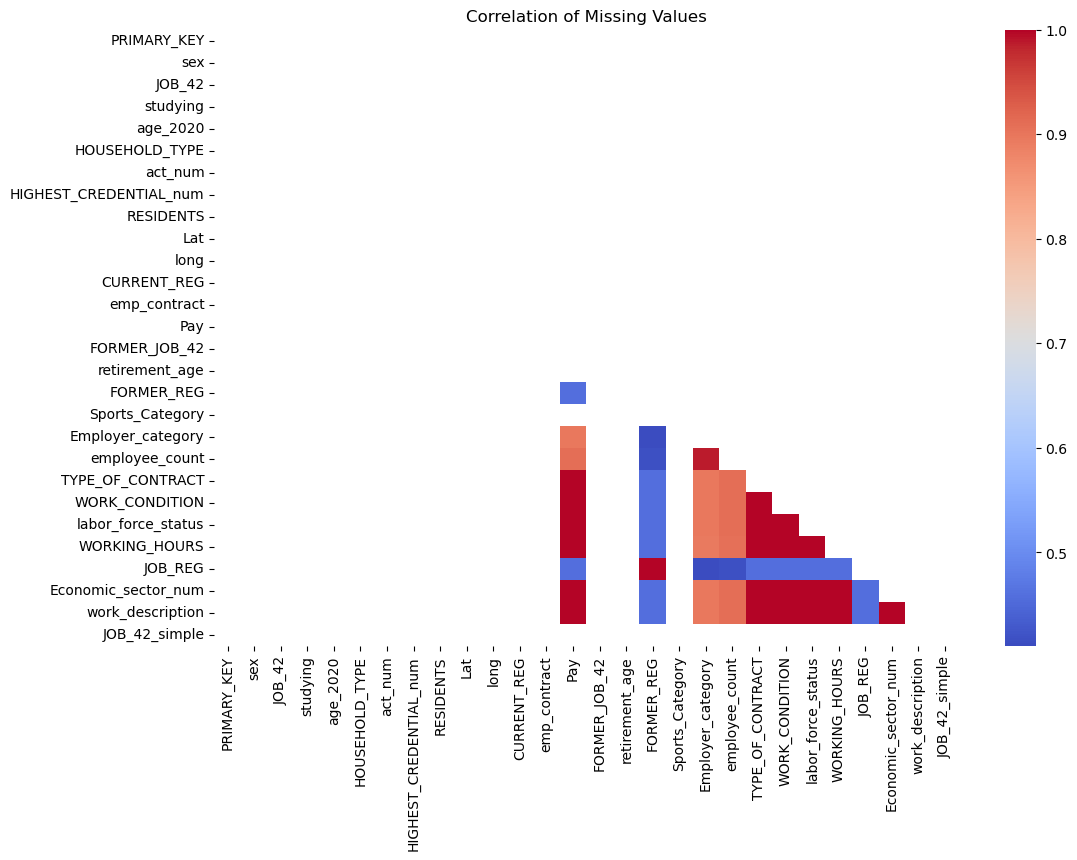

In [60]:
print("Correlation of Missing Values for Learn Data")
plot_na_correlation(learn_data)

print("Correlation of Missing Values for Test Data")
plot_na_correlation(test_data)

In [61]:
def nb_na_values_per_rows(df):
    """
    Group rows with exactly X missing values by JOB_42 categories 
    """

    # Count the number of missing values per row
    df['missing_count'] = df.isnull().sum(axis=1)

    # Filter rows with exactly 1 missing value
    filtered_df = df[df['missing_count'] == 11].copy() #adjust accordingly

    # Identify all columns with missing values for each row
    filtered_df['Missing_Variables'] = filtered_df.apply(
        lambda row: ', '.join(row.index[row.isnull()].tolist()), axis=1
    )

    # Group by JOB_42 and calculate counts of rows with 1 missing value
    job_42_counts = filtered_df.groupby('JOB_42').size().reset_index(name='Count')

    # Calculate total individuals per JOB_42
    total_counts = df['JOB_42'].value_counts().reset_index()
    total_counts.columns = ['JOB_42', 'Total']

    # Merge with filtered counts to calculate percentages
    job_42_summary = pd.merge(job_42_counts, total_counts, on='JOB_42')
    job_42_summary['Percentage'] = ((job_42_summary['Count'] / job_42_summary['Total']) * 100).round(1)

    # Add a list of all missing variables per JOB_42 category
    missing_variable_summary = (
        filtered_df.groupby('JOB_42')['Missing_Variables']
        .apply(lambda x: ', '.join(x.unique()))
        .reset_index()
    )
    missing_variable_summary.columns = ['JOB_42', 'Missing_Variables']

    # Merge the summary with the missing variable details
    result = pd.merge(job_42_summary, missing_variable_summary, on='JOB_42')

    # Drop the temporary column
    df.drop(columns=['missing_count'], inplace=True)

    return result.sort_values(by='Percentage', ascending=False)


In [62]:
nb_values = nb_na_values_per_rows(learn_data)
print(nb_values)

    JOB_42  Count  Total  Percentage  \
0  csp_7_1    649    649       100.0   
1  csp_7_2   1034   1034       100.0   
2  csp_7_4    215   1220        17.6   
3  csp_7_5    183   2757         6.6   
4  csp_7_8      2   3375         0.1   

                                   Missing_Variables  
0  Pay, FORMER_REG, Employer_category, employee_c...  
1  Pay, FORMER_REG, Employer_category, employee_c...  
2  Pay, FORMER_REG, Employer_category, employee_c...  
3  Pay, FORMER_REG, Employer_category, employee_c...  
4  Pay, FORMER_REG, Employer_category, employee_c...  


In [66]:
def na_values_by_group_for_column(df, group_col, target_col):
    # Group by `group_col` and calculate missing values for `target_col`
    grouped = df.groupby(group_col).apply(lambda group: group[target_col].isnull().sum())
    total_rows = df.groupby(group_col).size()  # Total rows per group
    missing_percent = (grouped / total_rows) * 100  # Calculate % of missing values

    # Combine counts and percentages into one DataFrame
    missing_table = pd.DataFrame({
        'Missing Values': grouped,
        '% of Total Values': missing_percent
    }).round(1)
    
    return missing_table

In [68]:
#learn_data["work_description"].value_counts()

# Sorting for numeric

In [70]:
learn_data["TYPE_OF_CONTRACT"].value_counts()

TYPE_OF_CONTRACT
CDI           26864
Unemployed    12727
AUT            1573
CDD             987
TTP             472
APP             300
TOA             181
Name: count, dtype: int64

In [72]:
columns_to_factorize = [  
    'JOB_42', 'JOB_REG', 'Economic_sector_num', 'work_description', 'employee_count',
    'retirement_age', 'FORMER_REG', 'TYPE_OF_CONTRACT', 'FORMER_JOB_42',
    'WORK_CONDITION', 'labor_force_status', 'emp_contract', 'Employer_category'
]  

# Function to sort and factorize columns while keeping missing values as NaN
def sort_and_factorize_with_na(data, columns):
    for column in columns:
        # Sort by the column while keeping NaN values intact
        data = data.sort_values(by=column, ascending=True, na_position='first')
        
        # Get factorized codes, skipping NaN values
        codes, uniques = pd.factorize(data[column], use_na_sentinel=True)
        
        # Assign codes to the column, replacing -1 (representing NaN) back with NaN
        data[column] = pd.Series(codes, index=data.index).replace(-1, pd.NA)
        data[column] = pd.to_numeric(data[column], errors='coerce').astype('category')
        
    return data.sort_values(by='PRIMARY_KEY', ascending=True)

# Apply the function to learn_data and test_data
learn_data = sort_and_factorize_with_na(learn_data, columns_to_factorize)
test_data = sort_and_factorize_with_na(test_data, columns_to_factorize)  

## Handling NA 

# Imputing NA for rows with only 1 NA

In [76]:
def impute_employer_category_with_1_missing(data):
    # Create a column that tracks if there is exactly one missing value per row
    data['missing_count'] = data.isnull().sum(axis=1)

    # Filter rows where there is exactly 1 missing value, and the missing value is in the 'Employer_category' column
    rows_with_1_missing_in_employer = data[data['missing_count'] == 1].index

    # If there are no such rows, just return the original data
    if rows_with_1_missing_in_employer.empty:
        data.drop(columns=['missing_count'], inplace=True)
        return data

    # Apply KNN Imputation only to rows where 'Employer_category' is missing
    knn_imputer = KNNImputer(n_neighbors=5)

    # Select only the rows where 'Employer_category' is missing
    encoded_df = data.loc[rows_with_1_missing_in_employer, ['Employer_category']]

    # Apply KNN imputation to the 'Employer_category' column
    imputed_array = knn_imputer.fit_transform(encoded_df)

    # Round and convert to integer (if necessary) to match original data type
    imputed_values = imputed_array.round().astype(int)

    # Update the original data with imputed values for 'Employer_category'
    data.loc[rows_with_1_missing_in_employer, 'Employer_category'] = imputed_values

    # Drop the temporary 'missing_count' column
    data.drop(columns=['missing_count'], inplace=True)

    return data



In [78]:
# Apply the function to learn_data
impute_employer_category_with_1_missing(learn_data)

,PRIMARY_KEY,sex,JOB_42,studying,age_2020,HOUSEHOLD_TYPE,target,act_num,HIGHEST_CREDENTIAL_num,RESIDENTS,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,JOB_REG,Economic_sector_num,work_description,JOB_42_simple
0,1,0,21,0,34,3,9.367020,1,10,14514,...,8.0,1.0,3.0,0.0,1.0,1470,10.0,6.0,2.0,5
1,5,1,36,0,80,7,8.648771,3,6,14514,...,8.0,1.0,3.0,0.0,1.0,793,5.0,3.0,3.0,7
2,7,0,6,0,63,4,10.792503,1,11,14514,...,NaN,NaN,NaN,NaN,NaN,<NA>,10.0,NaN,NaN,3
3,8,1,10,0,50,4,8.508222,1,9,14514,...,8.0,1.0,3.0,0.0,1.0,1201,0.0,1.0,0.0,3
4,10,0,23,0,68,7,8.966272,2,6,14514,...,9.0,7.0,6.0,3.0,3.0,0,10.0,10.0,4.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,100077,0,39,1,29,5,11.154438,6,6,28540,...,9.0,7.0,6.0,3.0,3.0,0,0.0,10.0,4.0,8
50039,100078,0,13,0,34,4,9.962345,1,9,28540,...,7.0,6.0,3.0,2.0,1.0,665,0.0,8.0,1.0,4
50040,100079,0,19,0,29,6,12.226288,1,8,28540,...,7.0,4.0,3.0,0.0,1.0,3000,0.0,8.0,2.0,5
50041,100081,1,39,0,57,3,8.965529,7,6,28540,...,9.0,7.0,6.0,3.0,3.0,0,0.0,10.0,4.0,8


In [80]:
def impute_working_hours_with_1_missing_values(df):
    """
    Imputes missing values by median within each JOB_42 category for rows with exactly 1 missing value (so WORKING HOURS)
    """
    # Count the number of missing values per row
    df['missing_count'] = df.isnull().sum(axis=1)

    # Filter rows with exactly 1 missing value
    filtered_df = df[df['missing_count'] == 1]

    # Iterate through rows with 1 missing value
    for index, row in filtered_df.iterrows():
        # Find the missing column
        missing_col = row[row.isnull()].index[0]

        # Get the JOB_42 category
        job_42_category = row['JOB_42']

        # Calculate the median of the missing column for the specific JOB_42 category
        median_value = df[df['JOB_42'] == job_42_category][missing_col].median()

        # Impute the missing value with the calculated median
        df.at[index, missing_col] = median_value

    # Drop the temporary column
    df.drop(columns=['missing_count'], inplace=True)

    return df

In [82]:
impute_working_hours_with_1_missing_values(learn_data)

,PRIMARY_KEY,sex,JOB_42,studying,age_2020,HOUSEHOLD_TYPE,target,act_num,HIGHEST_CREDENTIAL_num,RESIDENTS,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,JOB_REG,Economic_sector_num,work_description,JOB_42_simple
0,1,0,21,0,34,3,9.367020,1,10,14514,...,8.0,1.0,3.0,0.0,1.0,1470,10.0,6.0,2.0,5
1,5,1,36,0,80,7,8.648771,3,6,14514,...,8.0,1.0,3.0,0.0,1.0,793,5.0,3.0,3.0,7
2,7,0,6,0,63,4,10.792503,1,11,14514,...,NaN,NaN,NaN,NaN,NaN,<NA>,10.0,NaN,NaN,3
3,8,1,10,0,50,4,8.508222,1,9,14514,...,8.0,1.0,3.0,0.0,1.0,1201,0.0,1.0,0.0,3
4,10,0,23,0,68,7,8.966272,2,6,14514,...,9.0,7.0,6.0,3.0,3.0,0,10.0,10.0,4.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,100077,0,39,1,29,5,11.154438,6,6,28540,...,9.0,7.0,6.0,3.0,3.0,0,0.0,10.0,4.0,8
50039,100078,0,13,0,34,4,9.962345,1,9,28540,...,7.0,6.0,3.0,2.0,1.0,665,0.0,8.0,1.0,4
50040,100079,0,19,0,29,6,12.226288,1,8,28540,...,7.0,4.0,3.0,0.0,1.0,3000,0.0,8.0,2.0,5
50041,100081,1,39,0,57,3,8.965529,7,6,28540,...,9.0,7.0,6.0,3.0,3.0,0,0.0,10.0,4.0,8


In [84]:
#impute_missing_values_by_job_42(learn_data)

# Imputing NA for rows with 2 NA

In [87]:
#learn_data["missing_count"].value_counts()

# Replacing NA with external values (for pay and working hours)

In [90]:
# Add section here to replace missing JOB_REG with CURRENT_REG for some JOB_42 categories
# - eg artisans, agriculture...!!!!!!!!!!!!!!!!

In [92]:
# Define job-specific pay and working hours
job_defaults = {
    'csp_1': {'Pay': 50000, 'WORKING_HOURS': 2860},  # Agriculture
    'csp_2_1': {'Pay': 24000, 'WORKING_HOURS': 2288},  # Artisans
    'csp_2_2': {'Pay': 39937, 'WORKING_HOURS': 2444},  # Commerçant
    'csp_2_3': {'Pay': 58248, 'WORKING_HOURS': 2704},  # Chefs d'enterprise
}

# Function to fill missing values for Pay and WORKING_HOURS
def fill_job_defaults(data, job_defaults):
    for job, defaults in job_defaults.items():
        if job == 'csp_1':
            # Special case: Handle 'startswith' condition for 'csp_1'
            job_condition = data['JOB_42'].astype(str).str.startswith(job)
        else:
            # Exact match for other job keys
            job_condition = data['JOB_42'] == job
        
        # Fill missing Pay and WORKING_HOURS
        data.loc[job_condition & data['Pay'].isna(), 'Pay'] = defaults['Pay']
        data.loc[job_condition & data['WORKING_HOURS'].isna(), 'WORKING_HOURS'] = defaults['WORKING_HOURS']

# Apply the function to the datasets
fill_job_defaults(learn_data, job_defaults)
fill_job_defaults(test_data, job_defaults)


In [94]:
def impute_rows_with_2_missing(data):
    # Add a column to count missing values per row
    data['missing_count'] = data.isnull().sum(axis=1)

    # Filter rows with exactly 2 missing values
    rows_with_2_missing = data[data['missing_count'] == 2].drop(columns='missing_count')

    # Create a copy for encoding
    encoded_df = rows_with_2_missing.copy()

    # Apply KNN Imputation
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_array = knn_imputer.fit_transform(encoded_df)

    # Recreate the DataFrame from imputed data
    imputed_df = pd.DataFrame(imputed_array, columns=encoded_df.columns, index=encoded_df.index)

    # Convert the imputed columns back to their original category types
    for col in imputed_df.columns:
        if isinstance(data[col].dtype, pd.CategoricalDtype):  # Updated dtype check
            # Map numeric codes back to original categories
            imputed_df[col] = pd.Categorical.from_codes(
                imputed_df[col].round().astype(int), 
                categories=data[col].cat.categories
            )
        else:
            # Keep non-categorical columns as they are
            imputed_df[col] = imputed_df[col]

    # Replace the imputed rows in the original dataset
    data.loc[rows_with_2_missing.index, :] = imputed_df

    # Drop the temporary column used for filtering
    data.drop(columns=['missing_count'], inplace=True)

    return data

# Apply the function to learn_data
learn_data = impute_rows_with_2_missing(learn_data)

In [96]:
print(missing_values_table(learn_data)) 
print(missing_values_table(test_data))

There are 11 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              6958               13.9
employee_count                 6958               13.9
WORKING_HOURS                  6944               13.9
Pay                            6939               13.9
TYPE_OF_CONTRACT               6939               13.9
WORK_CONDITION                 6939               13.9
labor_force_status             6939               13.9
Economic_sector_num            6939               13.9
work_description               6939               13.9
FORMER_REG                     2097                4.2
JOB_REG                        2097                4.2
There are 11 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              8260               16.5
employee_count                 8080               16.1
WORKING_HOURS                  6879               13.7
Pay                       

In [98]:
missing_values_learn_data = missing_values_table(learn_data)
missing_values_test_data = missing_values_table(test_data)

# Convert the missing values table to LaTeX format
latex_learn_data = missing_values_learn_data.to_latex(float_format="%.2f")
latex_test_data = missing_values_test_data.to_latex(float_format="%.2f")

with open("./missing_values_learn_data.tex", "w") as file:
    file.write(latex_learn_data)
with open("./missing_values_test_data.tex", "w") as file:
    file.write(latex_test_data) 

There are 11 columns that have missing values.
There are 11 columns that have missing values.


## Enconding the dataset to ease imputation and use of ML models

In [101]:
#for linear regression (MICE, KNN) I need only number :

#do one-hot encoding for "labor_force status", but with catagegory being 0(=??), Employed_missing, Unemployed and Other (=only being 6%)
#do one hot-encodung for "type_of_contratct" with CDI, Unemployed, Employed_Missing, Other (=only being 12%)
#do one_hot_encding for "work_condition" with Unemployed, P, Other(=only being 17%)
#do one hot_econding for "emp_contract", with EMP1-6, Unemployed, EMP2-1, Other (=being 12%)
#do one hot encoding for "sport" but with a "Other" category
#do one hot encdoding for "employer_category" with 1 to 7 being "Others"
#for "act" do one hot encoding but maybe merge stay at home people with inactif + drop less than 14years olds as nobody in our data is 

#use "work condition" instead of JOB_42 and then do one-hot-encdoding
#do one-hot-encoding for "household_type"
#do one hot encoding for "Economic_sector_num" and "work_description" 
#do one hot encdoding for "REG_JOB" and "FORMER_REG"

#can keep it as is for "employee count" because here the ordinality make sense
#can keep as is for "highest_credential" because the ordinality make sense here for education
#can keep as is for the location of insee code because here the ordinality make sense

# Building the pipeline

In [103]:
learn_data.dtypes

PRIMARY_KEY                  int64
sex                          int64
JOB_42                    category
studying                     int64
age_2020                     int64
HOUSEHOLD_TYPE               int64
target                     float64
act_num                      int64
HIGHEST_CREDENTIAL_num       int64
RESIDENTS                    int64
Lat                        float64
long                       float64
CURRENT_REG                  Int64
emp_contract              category
Pay                          Int64
FORMER_JOB_42             category
retirement_age            category
FORMER_REG                category
Sports_Category              int64
Employer_category         category
employee_count            category
TYPE_OF_CONTRACT          category
WORK_CONDITION            category
labor_force_status        category
WORKING_HOURS                Int64
JOB_REG                   category
Economic_sector_num       category
work_description          category
JOB_42_simple       

In [104]:
def mice_imputation_for_categorical(data, columns_to_impute):
    """
    This function imputes missing values for categorical variables using MICE and rounds imputations to 0 decimal places.
    
    :param data: pandas DataFrame, dataset with missing values.
    :param columns_to_impute: list, columns to apply MICE imputation.
    
    :return: pandas DataFrame, dataset with imputed values rounded to 0 decimal places.
    """
    # Step 1: Ensure all columns are in numeric format (Label Encoding if necessary)
    data_encoded = data.copy()

    # Step 2: Apply MICE using IterativeImputer
    mice_imputer = IterativeImputer(max_iter=10, random_state=42)
    imputed_data = mice_imputer.fit_transform(data_encoded[columns_to_impute])
    
    # Step 3: Convert the imputed data back to a DataFrame
    imputed_data_df = pd.DataFrame(imputed_data, columns=columns_to_impute, index=data_encoded.index)
    
    # Step 4: Round the imputed values to 0 decimal places
    imputed_data_df = imputed_data_df.round(0)

    # Step 5: Combine the imputed data with the rest of the original dataset
    data_imputed = data.copy()
    data_imputed[columns_to_impute] = imputed_data_df[columns_to_impute]
    
    return data_imputed

# Example usage
columns_to_impute = [
    'Employer_category', 'employee_count', 'WORKING_HOURS', 
    'Pay', 'TYPE_OF_CONTRACT', 'WORK_CONDITION', 
    'labor_force_status', 'Economic_sector_num', 'work_description',
    'FORMER_REG', 'JOB_REG'
]

# Apply the function to your dataset
imputed_data = mice_imputation_for_categorical(learn_data, columns_to_impute)

# Display the imputed data
print(imputed_data)


       PRIMARY_KEY  sex JOB_42  studying  age_2020  HOUSEHOLD_TYPE     target  \
0                1    0     21         0        34               3   9.367020   
1                5    1     36         0        80               7   8.648771   
2                7    0      6         0        63               4  10.792503   
3                8    1     10         0        50               4   8.508222   
4               10    0     23         0        68               7   8.966272   
...            ...  ...    ...       ...       ...             ...        ...   
50038       100077    0     39         1        29               5  11.154438   
50039       100078    0     13         0        34               4   9.962345   
50040       100079    0     19         0        29               6  12.226288   
50041       100081    1     39         0        57               3   8.965529   
50042       100082    1     24         0        51               1  11.928150   

       act_num  HIGHEST_CRE

In [106]:
imputed_data["TYPE_OF_CONTRACT"].value_counts()

TYPE_OF_CONTRACT
3.0    26864
6.0    12727
4.0     7120
1.0     1573
2.0      987
5.0      472
0.0      300
Name: count, dtype: int64

In [125]:
print(missing_values_table(learn_data)) 
print(missing_values_table(imputed_data))

There are 11 columns that have missing values.
                     Missing Values  % of Total Values
Employer_category              6958               13.9
employee_count                 6958               13.9
WORKING_HOURS                  6944               13.9
Pay                            6939               13.9
TYPE_OF_CONTRACT               6939               13.9
WORK_CONDITION                 6939               13.9
labor_force_status             6939               13.9
Economic_sector_num            6939               13.9
work_description               6939               13.9
FORMER_REG                     2097                4.2
JOB_REG                        2097                4.2
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [127]:
imputed_data

,PRIMARY_KEY,sex,JOB_42,studying,age_2020,HOUSEHOLD_TYPE,target,act_num,HIGHEST_CREDENTIAL_num,RESIDENTS,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,JOB_REG,Economic_sector_num,work_description,JOB_42_simple
0,1,0,21,0,34,3,9.367020,1,10,14514,...,8.000000,1.000000,3.000000,0.000000,1.000000,1470.000000,10.0,6.000000,2.000000,5
1,5,1,36,0,80,7,8.648771,3,6,14514,...,8.000000,1.000000,3.000000,0.000000,1.000000,793.000000,5.0,3.000000,3.000000,7
2,7,0,6,0,63,4,10.792503,1,11,14514,...,7.590534,4.669581,3.857342,1.250095,1.742614,927.874912,10.0,6.963815,2.605543,3
3,8,1,10,0,50,4,8.508222,1,9,14514,...,8.000000,1.000000,3.000000,0.000000,1.000000,1201.000000,0.0,1.000000,0.000000,3
4,10,0,23,0,68,7,8.966272,2,6,14514,...,9.000000,7.000000,6.000000,3.000000,3.000000,0.000000,10.0,10.000000,4.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,100077,0,39,1,29,5,11.154438,6,6,28540,...,9.000000,7.000000,6.000000,3.000000,3.000000,0.000000,0.0,10.000000,4.000000,8
50039,100078,0,13,0,34,4,9.962345,1,9,28540,...,7.000000,6.000000,3.000000,2.000000,1.000000,665.000000,0.0,8.000000,1.000000,4
50040,100079,0,19,0,29,6,12.226288,1,8,28540,...,7.000000,4.000000,3.000000,0.000000,1.000000,3000.000000,0.0,8.000000,2.000000,5
50041,100081,1,39,0,57,3,8.965529,7,6,28540,...,9.000000,7.000000,6.000000,3.000000,3.000000,0.000000,0.0,10.000000,4.000000,8


In [33]:
#NEED TO BE MODIFIED - GET WORKING FUNCTION FIRST

# Specify the columns that need MICE imputation
cat_columns = ["TYPE_OF_CONTRACT", "WORK_CONDITION", "labor_force_status", "work_description", 'Economic_sector_num']
columns_to_impute = ["Employer_category", "employee_count"]

# Define the combined pipeline
pipeline = Pipeline([
    ('job_42_imputer', ImputeMissingValuesByJob42()) #- for when theres 1 missing value/col per row 
    #('impute_averages', ImputeMissingValues()), #this one was for working hours and pay specifically?
    ('mice_imputer', MICEImputer(columns_to_impute=columns_to_impute)), 
    ('knn_imputer', Custom_KNNImputer(columns_to_impute_2=columns_to_impute_2)),
])


## LINEAR MODEL

In [ ]:
#the encoding is done using the previous function (encoding_datataset)

In [ ]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(learn_lin)) 

In [ ]:
#move this for after train test splitting
learn_lin = pipeline.fit_transform(learn_data)

In [38]:
x_train_lin = learn_lin.drop(columns=["target"])
y_train_lin = learn_lin["target"]

In [39]:
X_train_lin, X_test_lin, Y_train_lin, Y_test_lin = train_test_split(x_train_lin,
                                                    y_train_lin, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
# Example GridSearchCV for Linear Regression
param_grid = {'fit_intercept': [True, False]}  # Define your hyperparameter grid

# Create a Linear Regression model
lr = LinearRegression()

# Perform grid search with cross-validation
lin_res = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5)

# Fit the GridSearchCV model
lin_res.fit(X_train_lin, Y_train_lin)

# Output the best model and its score
print(f"Best model: {lin_res.best_estimator_}")
print(f"Best score: {lin_res.best_score_}")


In [ ]:
train_predictions = lin_res.predict(X_train_lin)
print("R² for training set: ", r2_score(Y_train_lin, train_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train_lin, lin_res.predict(X_train_lin)))

In [ ]:
train_predictions = lin_res.predict(X_train_lin)
test_predictions = lin_res.predict(X_test_lin)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_lin, y=test_predictions, alpha=0.6, color="blue")
plt.plot([y_train_lin.min(), y_train_lin.max()], [y_train_lin.min(), y_train_lin.max()], "--r", linewidth=2)  # Ideal predictions
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.savefig("./Prediction_vs_True_linear.png", format='png', dpi=300)  
plt.show()

## RANDOM FOREST

In [36]:
learn_rf = pipeline.fit_transform(learn_data)

In [37]:
x_train_rf = learn_rf.drop(columns=["target"])
y_train_rf = learn_rf["target"]

X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(x_train_rf,
                                                    y_train_rf, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [38]:
param_grid_rf = {     # Number of trees in the forest
    'max_depth': [5, 10, 30, 50],    
    'min_samples_split': [5, 10, 20]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)  #need to add that in the pipeline 

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

In [39]:
# Fit the model on the training data
rf_res = rf_search.fit(X_train_rf, Y_train_rf)

In [ ]:
# Get the best model after GridSearchCV
best_model_rf = rf_res.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_res.best_score_}")

In [ ]:
cv_scores = cross_val_score(best_model_rf, X_train_rf, Y_train_rf, cv=5, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Average R2: {np.mean(cv_scores):.2f}")

In [ ]:
train_predictions = best_model_rf.predict(X_train_rf)
test_predictions = best_model_rf.predict(X_test_rf)

print("R² for training set: ", r2_score(Y_train_rf, train_predictions))
print("R² for test set: ", r2_score(Y_test_rf, test_predictions))
print("RMSE on the learning set:", root_mean_squared_error(Y_train_rf, best_model_rf.predict(X_train_rf)))
print("RMSE on the test set:", root_mean_squared_error(Y_test_rf, best_model_rf.predict(X_test_rf)))

In [43]:
error_metrics = pd.DataFrame({
    'Metric': ['R²', 'RMSE'],
    'Train': [r2_score(Y_train_rf, train_predictions), root_mean_squared_error(Y_train_rf, best_model_rf.predict(X_train_rf))],
    'Test': [r2_score(Y_test_rf, test_predictions), root_mean_squared_error(Y_test_rf, best_model_rf.predict(X_test_rf))]
})

# Set 'Metric' as the index to have a clean format
error_metrics.set_index('Metric', inplace=True)

# Convert to LaTeX format
error_metrics_table = error_metrics.to_latex(index=True, float_format="%.2f")

with open("./error_metrics.tex", "w") as file:
    file.write(error_metrics_table)

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test_rf, y=test_predictions, alpha=0.6, color="blue")
plt.plot([y_train_rf.min(), y_train_rf.max()], [y_train_rf.min(), y_train_rf.max()], "--r", linewidth=2)  # Ideal predictions
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.savefig("./Prediction_vs_True_rf.png", format='png', dpi=300)  
plt.show()

## EXTRA ANALYISIS

In [ ]:
# Calculate correlation
correlation_matrix = learn_data.corr()

# Find correlations with the target variable
target_corr = correlation_matrix['target'].sort_values(ascending=False)

print(target_corr)

target_corr_table = target_corr.to_latex(index=False, float_format="%.2f")

with open("./target_corr.tex", "w") as file:
    file.write(target_corr_table)

In [ ]:
# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': x_train_rf.columns,
    'Importance': best_model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

feature_importances_table = feature_importances.to_latex(index=False, float_format="%.2f")

with open("./feature_importances.tex", "w") as file:
    file.write(feature_importances_table)